<center><h1> Redes Neurais Convolucionais </h1> <center>

<center><h2> Pytorch </h2> <center>
    
<center><h3> CIFAR10 Dataset</h3> <center>

<center><img src="images/cifar10.png"/></center>

* Torchvision :
    * Possui loaders com alguns datasets como Imagenet, CIFAR10, MNIST, etc.
    * Possui transforms para realizar transformações nas imagens
    
* Para esse exemplo vamos usar o dataset CIFAR10 que possui classes como:
    * Aeronaves
    * Carros
    * Pássaros
    * Gatos
    * Veados
    * Cachorros
    * Sapos
    * Cavalos
    * Navios
    * Caminhões
    

# Importando os dados

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch

# Número de observações por batch
batch_size = 10
# Percentagem de dados para validação
validation_size = 0.2

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # media e desvio padrao
                                ])
                               

train_data = datasets.CIFAR10('Cifar10_data', train=True,
                              download=True, transform=transform)

test_data = datasets.CIFAR10('Cifar10_data', train=False,
                             download=True, transform=transform)

# indices
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)

limit = int(np.floor(validation_size * num_train))

train_idx, validation_idx = indices[limit:], indices[:limit]

# amostras randomicas de dados da lista de índices, sem substituição .
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

# Prepara os dada loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
    
validationloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=validation_sampler)
   
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size )

classes = ('aeronave', 'carro', 'passaro', 'gato',
           'veado', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhao')

Files already downloaded and verified
Files already downloaded and verified


# Visualizando as imagens

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img): 
    img = (img * 0.5) + 0.5  # desnormalizar imagens
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # converter de tenror para numpy image
 

In [5]:
trainloader

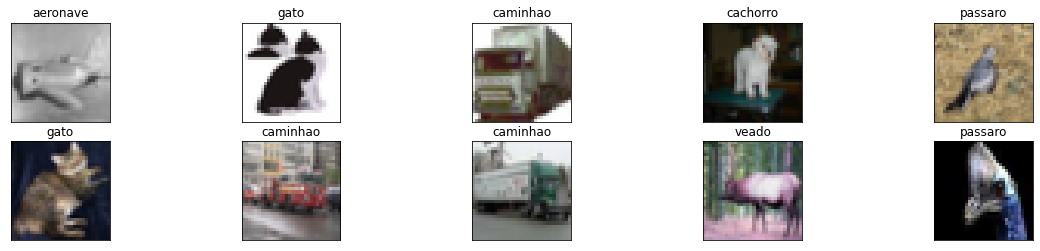

In [6]:
import numpy as np
# Um batch de dados de treino
dataiter = iter(trainloader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(20, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# Definindo nossa rede convolucional

* Para calcular o tamanho espacial da saida podemos usar a fórmula `((N − F + 2P) / S) + 1`.
* onde:
    * N : Dimensão da imagem de entrada
    * F : Dimensão do Filtro
    * P : O padding
    * S : O stride 

* Lembrando que um maxpooling de (kernel_size = 2,stride = 2) diminui pela metade a dimensão da imagem nos eixos x e y 

<center><img src="images/cifar10-cnn1.png"/></center>

<center><img src="images/cifar10-model.png"/></center>

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0,...)                                  
        self.pool = nn.MaxPool2d(2, 2)    # MaxPool2d(kernel_size, stride=None, padding=0, ...)
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


cnn = CNN()

.

# Define Loss function e otimizador

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

# Treinando o modelo

<center><img src="images/train_valid_error.png"/></center>

In [10]:
import os

In [11]:
# Épocas de treinamento
n_epochs = 5

validation_loss_min = np.Inf 

model_path = './model/'
file_name = 'cnn_model.pth'
if not os.path.exists(model_path): 
        os.makedirs(model_path)
        
for epoch in range(1, n_epochs+1): # de 1 a 5
    
    # inicia valores de loss de treino e validação
    train_loss = 0
    validation_loss = 0
    
    ### treinar o modelo ###
    cnn.train()
    for data, target in trainloader:
        
        optimizer.zero_grad()                     # zera os gradientes de todas as variaveis
        
        # forward + backward + optimize
        output = cnn(data)
        loss = criterion(output, target)           # calcula loss da batch - CrossEntropyLoss()
        loss.backward()                            # Computa o gradiente da loss com relação aos parametros do modelo
        optimizer.step()                           # Update dos parametros
        train_loss += loss.item()*data.size(0)     # Atualização da training loss
        
   ### validação do modelo ###
    cnn.eval()
    for data, target in validationloader:

        output = cnn(data)

        loss = criterion(output, target)           # calcula loss da batch
        validation_loss += loss.item()*data.size(0)     # Atualiza a validation loss média
    
    # Cálculo dos valores de loss médios
    train_loss = train_loss/len(trainloader.sampler)
    validation_loss = validation_loss/len(validationloader.sampler)
    
    print(f'Epoch: {epoch}', end = '\t')
    print(f'Training Loss: {train_loss}', end = '\t')
    print(f'Validation Loss: {validation_loss}', end = '\t')
       
    # Salva o modelo resultante, caso a validation loss tenha diminuido
    if validation_loss <= validation_loss_min:
        print(f'Validation loss Diminuiu ( saiu de {validation_loss_min} --> para {validation_loss}).  Modelo será salvo em {model_path + file_name}')
        torch.save(cnn.state_dict(), model_path + file_name)
        validation_loss_min = validation_loss

Epoch: 1	Training Loss: 2.062890833377838	Validation Loss: 1.684909445643425	Validation loss Diminuiu ( saiu de inf --> para 1.684909445643425).  Modelo será salvo em ./model/cnn_model.pth
Epoch: 2	Training Loss: 1.577234018549323	Validation Loss: 1.5139545117616653	Validation loss Diminuiu ( saiu de 1.684909445643425 --> para 1.5139545117616653).  Modelo será salvo em ./model/cnn_model.pth
Epoch: 3	Training Loss: 1.4115739924907684	Validation Loss: 1.3616797051429748	Validation loss Diminuiu ( saiu de 1.5139545117616653 --> para 1.3616797051429748).  Modelo será salvo em ./model/cnn_model.pth
Epoch: 4	Training Loss: 1.3003676651343703	Validation Loss: 1.3068426074683666	Validation loss Diminuiu ( saiu de 1.3616797051429748 --> para 1.3068426074683666).  Modelo será salvo em ./model/cnn_model.pth
Epoch: 5	Training Loss: 1.2216629017665983	Validation Loss: 1.2341030330657958	Validation loss Diminuiu ( saiu de 1.3068426074683666 --> para 1.2341030330657958).  Modelo será salvo em ./model

# Testando o modelo com dados de teste

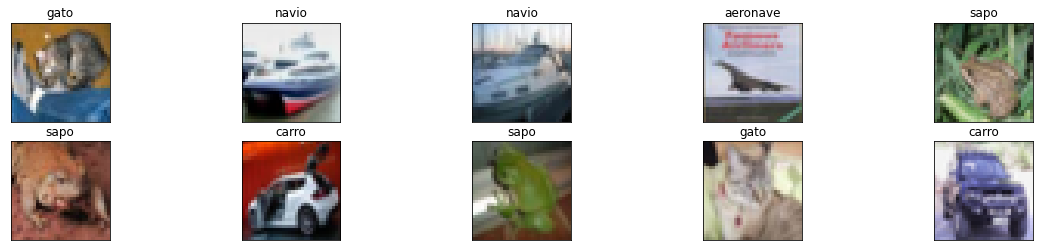

In [12]:
# Um batch de dados de teste
dataiter = iter(testloader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(20, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# Importa modelo treinado

In [13]:

cnn.load_state_dict(torch.load(model_path + file_name))


<All keys matched successfully>

# Testando o modelo com dados de teste

In [14]:

test_loss = 0.0
correct_class = list(0. for i in range(10))
total_class = list(0. for i in range(10))

cnn.eval()
for data, target in testloader:
    output = cnn(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)                         # Converte as probabilides do output para a classe predita
    correct_tensor = pred.eq(target.data.view_as(pred))    # Compara as predições com os valores reais
    correct = np.squeeze(correct_tensor.numpy()) 

    for i in range(batch_size):                            # Calcula acuracia para cada classe
        label = target.data[i]
        correct_class[label] += correct[i].item()
        total_class[label] += 1


for i in range(10):
    if total_class[i] > 0:
        print('Acurácia de teste da classe {} : {} '.format(
            classes[i], 100 * correct_class[i] / total_class[i]))

print('\n\tAcuracia Total: {}'.format(100. * np.sum(correct_class) / np.sum(total_class)))
    

Acurácia de teste da classe aeronave : 56.5 
Acurácia de teste da classe carro : 59.4 
Acurácia de teste da classe passaro : 42.5 
Acurácia de teste da classe gato : 42.5 
Acurácia de teste da classe veado : 46.9 
Acurácia de teste da classe cachorro : 41.2 
Acurácia de teste da classe sapo : 71.8 
Acurácia de teste da classe cavalo : 62.0 
Acurácia de teste da classe navio : 65.5 
Acurácia de teste da classe caminhao : 68.7 

	Acuracia Total: 55.7


---

.

.